In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator
import torch
import torch.optim as optim

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils
from tqdm import tqdm
import evotorch
import ray

os.environ['PYTHONPATH'] = "/home/thahit/github/Recommender_Sim"
ray.init(ignore_reinit_error=True)


2024-08-05 00:17:44,327	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.19
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8265


In [2]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [3]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [4]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [5]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [6]:
state = torch.zeros((1, state_size))

In [7]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(200)]
samples = np.array(samples)
samples

array([[1.4],
       [3.8],
       [0. ],
       [0.2],
       [1.9],
       [0.8],
       [2.5],
       [3.1],
       [1.8],
       [0.2],
       [3.2],
       [1. ],
       [0.1],
       [0.3],
       [1.5],
       [0.5],
       [0.9],
       [1.3],
       [0.5],
       [2.2],
       [1.7],
       [0.7],
       [0.5],
       [2.4],
       [2.9],
       [2.5],
       [3.6],
       [0.1],
       [0.9],
       [2.6],
       [2.7],
       [0. ],
       [1.4],
       [2.5],
       [2.8],
       [2.6],
       [1.1],
       [1. ],
       [1.3],
       [0.5],
       [3.1],
       [1.1],
       [4.1],
       [0. ],
       [4.3],
       [0. ],
       [1.9],
       [5.1],
       [3.7],
       [0.8],
       [0.9],
       [0.7],
       [0.1],
       [0.6],
       [1.7],
       [0.8],
       [1.8],
       [1.7],
       [3.2],
       [3.8],
       [0.2],
       [0.9],
       [0.4],
       [0.7],
       [0.4],
       [0.2],
       [0.3],
       [1.9],
       [2.9],
       [0.7],
       [1.3],
      

feed in true values for fake models, 


/tmp/ipykernel_30894/2138906594.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)


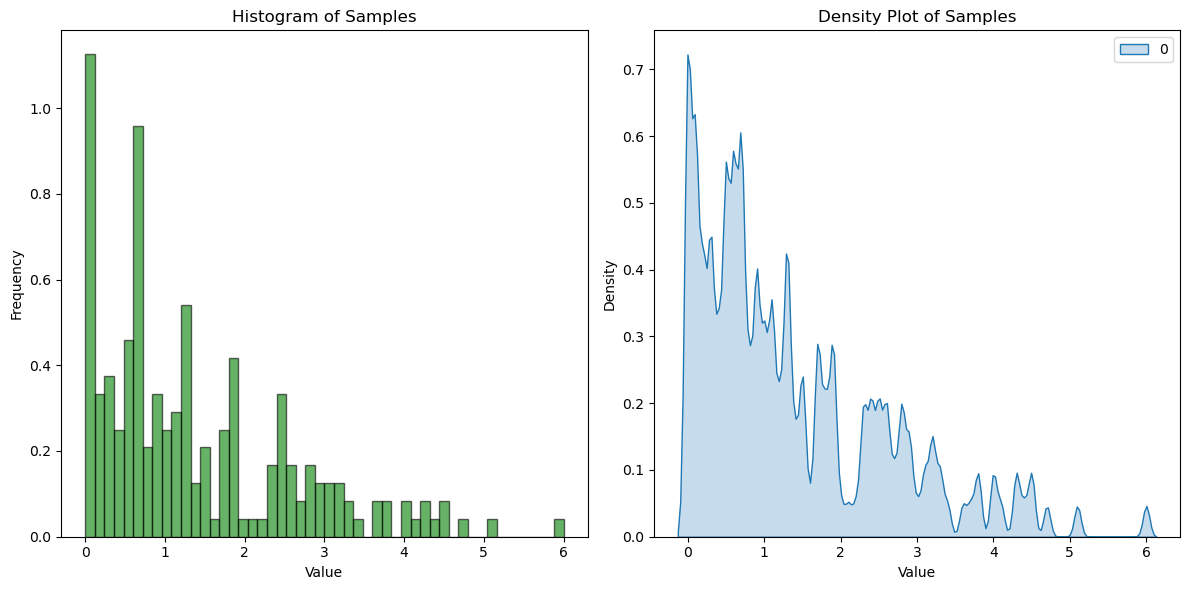

In [8]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [9]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path =torch.tensor(sample_path)
sample_path

tensor([[3.0000],
        [3.1000],
        [5.6000],
        [6.9000],
        [7.3000]])

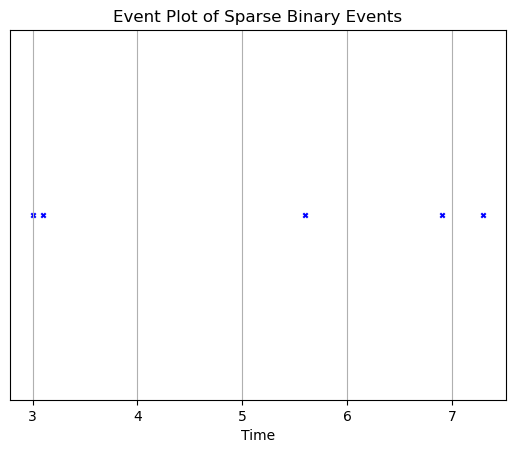

In [10]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


# Train Gradient Descent
Not working

In [11]:
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()

        #return results
        
        #loss calculation

In [12]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [13]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [14]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.001,
                        weight_decay=1e-7)


In [15]:
#train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
#            optimizer=optimizer, num_epochs=30, num_tries=10)

# Train via Evolution

In [16]:
from evotorch.algorithms import PGPE, CMAES
from evotorch.logging import PandasLogger
from functools import partial


In [17]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [18]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [19]:

def eval_single(model, path, scoring_func, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    loss = 0.
    #results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return loss


eval_single_partial = partial(eval_single, path=sample_path, scoring_func=utils.energy_score_loss,
                              num_tries=20)

In [20]:
eval_single_partial(train_model)

tensor(82.7985)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Single_path_problem = evotorch.neuroevolution.NEProblem(
    objective_sense="min",
    network= train_model,
    #network=Toy_intensity_Generator,
    #network_args = {"hyperparameter_dict": hyperparameter_dict},
    network_eval_func=eval_single_partial,
    device=device,
    num_actors = 20,
)

In [22]:


searcher = PGPE(
    Single_path_problem,
    popsize=30,
    radius_init=2.25,
    center_learning_rate=0.02,
    stdev_learning_rate=0.1,
)
'''
searcher = CMAES(
    Single_path_problem,
    popsize=20,  # Example parameter, adjust as needed
    learning_rate=0.1  # Example parameter, adjust as needed
)
'''
logger = PandasLogger(searcher)
searcher.run(100)

/home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/evotorch/core.py:3020: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  shares_storage = self._data.storage().data_ptr() == source._data.storage().data_ptr()


(EvaluationActor pid=32422) /home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/evotorch/core.py:3020: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(EvaluationActor pid=32422)   shares_storage = self._data.storage().data_ptr() == source._data.storage().data_ptr()


1 epoch = 50(population) * 20(samples for expectation) * 1(number of paths) * 10'000(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 300m NN calls per epoch

for much worse approximation and still way too much compute:<br>
1 epoch = 20(population) * 20(samples for expectation) * 1(number of paths) * 100(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 1.2m NN calls per epoch


<Axes: xlabel='iter'>

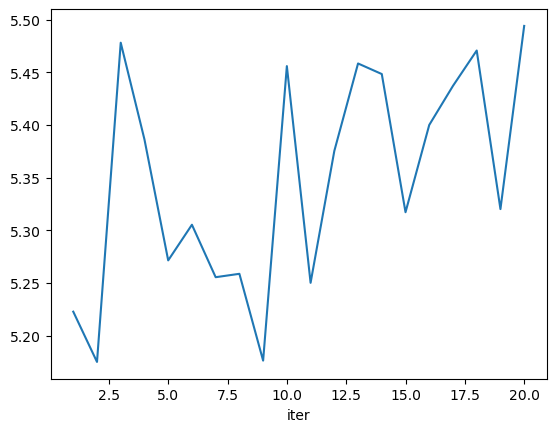

In [ ]:
logger.to_dataframe().mean_eval.plot()


In [ ]:
trained_network = Single_path_problem.parameterize_net(searcher.status["center"])


In [ ]:
wfwf

NameError: name 'wfwf' is not defined

In [ ]:
problem = Problem(
  "min",
  norm,
  initial_bounds=(-10.0, 10.0),
  solution_length=100,
  vectorized=True,
  # device="cuda",  # Enable for GPU support
)

In [ ]:
population_size = 50
num_generations = 20

population = evotorch.CMA(
    population_size=population_size,
    sigma=0.5,  # Standard deviation
    max_generations=num_generations
)

AttributeError: module 'evotorch' has no attribute 'CMA'

In [ ]:
<dv<sd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 3.5 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 6.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 4.2 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 7.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
asfawfe

NameError: name 'asfawfe' is not defined

In [ ]:
'''
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.as_tensor(results).detach().numpy()  # Timestamps for the second time series

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Time Series 1', s=100, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Time Series 2', s=100, marker='x')

# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Time Series 1', 'Time Series 2'])
ax.set_title('Comparison of Two Time Series')
ax.legend()
ax.grid(True)

# Display the plot
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Example data: replace these with your actual time series data\ntime_series_1 = sample_path # Timestamps for the first time series\ntime_series_2 = torch.as_tensor(results).detach().numpy()  # Timestamps for the second time series\n\n# Create a figure and axis\nfig, ax = plt.subplots(figsize=(10, 6))\n\n# Plot the first time series\nax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Time Series 1', s=100, marker='o')\n\n# Plot the second time series\nax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Time Series 2', s=100, marker='x')\n\n# Add labels, legend, and grid\nax.set_xlabel('Time')\nax.set_yticks([1, 2])\nax.set_yticklabels(['Time Series 1', 'Time Series 2'])\nax.set_title('Comparison of Two Time Series')\nax.legend()\nax.grid(True)\n\n# Display the plot\nplt.show()\n"

In [ ]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

u: tensor([0.9565]) 	 h: tensor([[0.0200]], grad_fn=<AddBackward0>)
u: tensor([0.8619]) 	 h: tensor([[0.0600]], grad_fn=<AddBackward0>)
u: tensor([0.0470]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.2447]) 	 h: tensor([[9.2101]], grad_fn=<AddBackward0>)
u: tensor([0.3120]) 	 h: tensor([[0.5900]], grad_fn=<AddBackward0>)
u: tensor([0.8404]) 	 h: tensor([[0.0700]], grad_fn=<AddBackward0>)
u: tensor([0.6431]) 	 h: tensor([[0.1900]], grad_fn=<AddBackward0>)
u: tensor([0.1453]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.7877]) 	 h: tensor([[0.1000]], grad_fn=<AddBackward0>)
u: tensor([0.6120]) 	 h: tensor([[0.2100]], grad_fn=<AddBackward0>)
u: tensor([0.6766]) 	 h: tensor([[0.1700]], grad_fn=<AddBackward0>)
u: tensor([0.2010]) 	 h: tensor([[16.9603]], grad_fn=<AddBackward0>)
u: tensor([0.8260]) 	 h: tensor([[0.0800]], grad_fn=<AddBackward0>)
u: tensor([0.0520]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.8644]) 	 h: tensor([[0.0600]], 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if sys.path[0] == "":


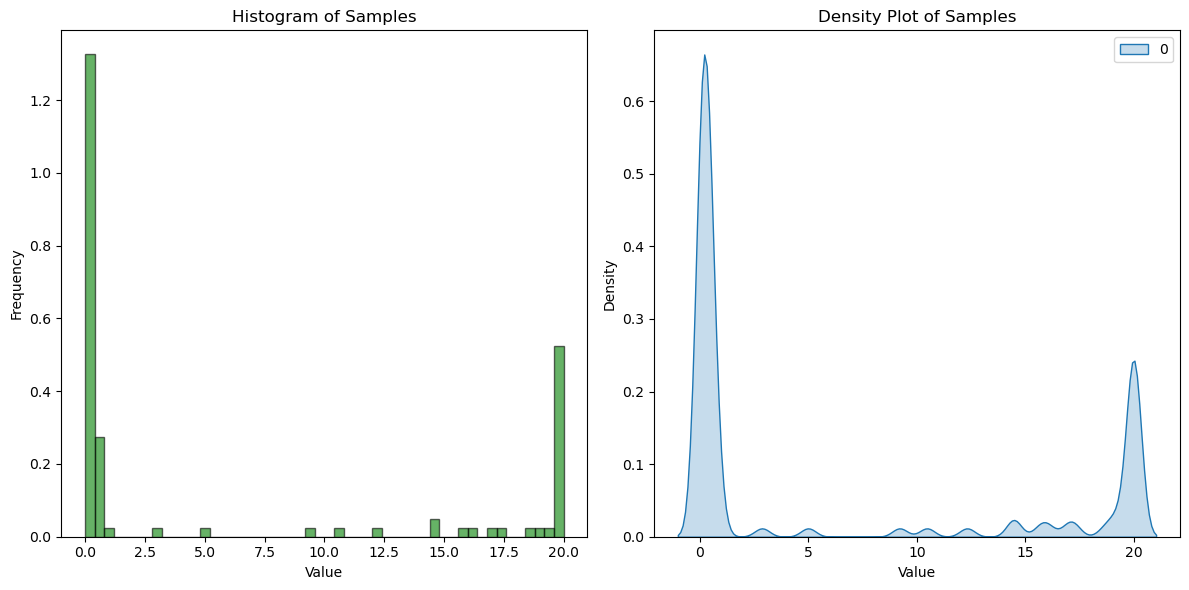

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
sample_paths = [torch.as_tensor(gen_model.sample_path(num_samples=7 + i%10)) for i in range(100)]

u: tensor([0.8357]) 	 h: tensor([[0.2700]])
u: tensor([0.8101]) 	 h: tensor([[0.3100]])
u: tensor([0.2139]) 	 h: tensor([[2.2300]])
u: tensor([0.1892]) 	 h: tensor([[2.2800]])
u: tensor([0.1829]) 	 h: tensor([[2.1500]])
u: tensor([0.4126]) 	 h: tensor([[1.0600]])
u: tensor([0.3895]) 	 h: tensor([[1.0800]])
u: tensor([0.4360]) 	 h: tensor([[1.2200]])
u: tensor([0.1618]) 	 h: tensor([[2.5900]])
u: tensor([0.8804]) 	 h: tensor([[0.1800]])
u: tensor([0.6596]) 	 h: tensor([[0.5700]])
u: tensor([0.6600]) 	 h: tensor([[0.5600]])
u: tensor([0.5202]) 	 h: tensor([[0.8500]])
u: tensor([0.7351]) 	 h: tensor([[0.3900]])
u: tensor([0.6919]) 	 h: tensor([[0.4600]])
u: tensor([0.3750]) 	 h: tensor([[1.4300]])
u: tensor([0.3858]) 	 h: tensor([[1.3700]])
u: tensor([0.7856]) 	 h: tensor([[0.3400]])
u: tensor([0.2851]) 	 h: tensor([[1.7200]])
u: tensor([0.9356]) 	 h: tensor([[0.0900]])
u: tensor([0.3759]) 	 h: tensor([[1.2700]])
u: tensor([0.5827]) 	 h: tensor([[0.6800]])
u: tensor([0.5802]) 	 h: tensor(

In [ ]:
from tqdm import tqdm
def train(model, paths, scoring_func, optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        avg_loss = 0
        #results = []
        for path in paths:
            last_t = 0
            state = torch.zeros((1, state_size))
            loss = 0.
            for timestep in path:
                current_pred = []
                for _ in range(num_tries):
                    current_pred.append(last_t + model.sample_one(state))
                current_pred = torch.stack(current_pred)
                #results.append(torch.mean(current_pred))
                loss += scoring_func(current_pred, timestep)
                delta = timestep-last_t
                last_t = timestep
                state = model.evolve_state(state, delta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()
            optimizer.zero_grad()
            avg_loss += loss
        print("loss: ", loss)
        

In [ ]:
results = train(train_model, sample_paths, scoring_func=utils.energy_score_loss,
                optimizer=optimizer, num_epochs=30, num_tries=20)

  0%|          | 0/30 [00:00<?, ?it/s]

u: tensor([0.3485]) 	 h: tensor([[0.4800]], grad_fn=<AddBackward0>)
u: tensor([0.7311]) 	 h: tensor([[0.1300]], grad_fn=<AddBackward0>)
u: tensor([0.7004]) 	 h: tensor([[0.1500]], grad_fn=<AddBackward0>)
u: tensor([0.1868]) 	 h: tensor([[19.8404]], grad_fn=<AddBackward0>)
u: tensor([0.9484]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.0248]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.9544]) 	 h: tensor([[0.0200]], grad_fn=<AddBackward0>)
u: tensor([0.2849]) 	 h: tensor([[2.0900]], grad_fn=<AddBackward0>)
u: tensor([0.4395]) 	 h: tensor([[0.3600]], grad_fn=<AddBackward0>)
u: tensor([0.3872]) 	 h: tensor([[0.4200]], grad_fn=<AddBackward0>)
u: tensor([0.9265]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.2972]) 	 h: tensor([[0.6700]], grad_fn=<AddBackward0>)
u: tensor([0.8400]) 	 h: tensor([[0.0700]], grad_fn=<AddBackward0>)
u: tensor([0.5358]) 	 h: tensor([[0.2700]], grad_fn=<AddBackward0>)
u: tensor([0.3007]) 	 h: tensor([[0.6500]], gr

  0%|          | 0/30 [00:34<?, ?it/s]

u: tensor([0.6625]) 	 h: tensor([[16.4203]], grad_fn=<AddBackward0>)


KeyboardInterrupt: 